In [4]:
import math
import numpy as np
import copy
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import inc.functions as fc
# from scipy.stats import nanmean
import os
import time
import scipy as sp
import random

In [5]:

sim_duration = 10000 # Durée de la simulation, en heures
canvas_grid_sep = 100  # Largeur de case de l'échiquier
canvas_width = 10*canvas_grid_sep  # Largeur du monde
canvas_height = 10*canvas_grid_sep  # Hauteur du monde
border_buffer = canvas_grid_sep

birth_range = 50  # Rayon de reproduction
eat_range = 100  # Vision de la bouffe (différence avec sight?)
eat_treshold = 15  # Distance avec bouffe pour qu'elle soit mangée
interact_treshold = 30

# facteur_multiplicatif_timer = 3
hunger_timer_default_mean = 30  # Jauge de vie (qui peut être montée en mangeant)
hunger_timer_default_std = 5
birth_timer_default_mean =  720 # Temps avant de pouvoir se reproduire
birth_timer_default_std = 50
mating_probability = 0.05  # Probabilité de reproduction
portee_taille_interv = [1,5] # Taille d'une portée (valeurs incluses équiprobables)

initial_TFT_population = 100
initial_TFTT_population = 0
initial_PO_population = 0
initial_JD_population = 0
initial_RD_population = 0
initial_number_of_animals = initial_JD_population + initial_PO_population + initial_TFT_population + initial_RD_population  # Nb initial d'animaux
JD_collaboration_prob = 0 # probabilité de collaboration des Judas (0 par défaut)
JD_birth_timer_factor = 1
JD_hunger_timer_factor = 1

initial_number_of_food = 150   # Qté de bouffe initiale
max_amount_of_food = 2000
animal_max_speed_mean = 25  # Vitesse maximale
animal_max_speed_std = 3
animal_sight_mean = 62  # Champ de vue moyen
animal_sight_std = 7
new_food_per_spawn = 75  # Qté de bouffe apparaissant # de 35 à 50 (20 avril Arthur)
period_food_spawn = 1  # Apparition à chaque "" heure
food_steering_force_increment = 10  # Force de changement de cap à la vue de la bouffe
collaboration = True # Est-ce que les espèces collaborent? ou PAS
interaction_delay = 3 #Interaction à chaque " " itération
max_number_of_interactions = 10
test_collab = False
racisme = False
nourriture_proportion = 0.1 #Proportion du hunger_timer rempli par une nourriture
collab_proportion = 0.0007
max_bourrage_de_face_ratio = 1.5 # en termes de hunger_timer_default
threshold_motivation_a_manger = 1.2
############################
payoffs = [3, 5, 0, 1] # [x , y , z,  w]   (tel que dans la matrice de payoffs du rapport)
############################
attracteurs = False
nb_attracteurs = 9
randomness_position_attracteur = 50
repartition_nourriture_autour_attracteur_std = canvas_grid_sep*0.7 
force_attractive = 0.8
random_force = 0.1

# Pré-calculs
nb_colonnes = canvas_width // canvas_grid_sep
nb_rangees = canvas_height // canvas_grid_sep
nourriture_proportion_collab = payoffs[0] * collab_proportion  # Collaboration mutuelle
nourriture_proportion_trahison = payoffs[1] * collab_proportion  # Trahison à un sens
penalite_se_faire_trahir = payoffs[2] * collab_proportion # Sucker's payoff
double_trahison_penalite = payoffs[3] * collab_proportion # Trahison double -> Backfire


params = {
    "sim_duration" : sim_duration, "canvas_width" : canvas_width, "canvas_height" : canvas_height, "canvas_grid_sep" : canvas_grid_sep, "birth_range" : birth_range,
    "eat_range" : eat_range, "eat_threshold" : eat_treshold, "hunger_timer_default_mean" : hunger_timer_default_mean,"hunger_timer_default_std" : hunger_timer_default_std,
    "birth_timer_default_mean" : birth_timer_default_mean, "birth_timer_default_std" : birth_timer_default_std, "mating_probability" : mating_probability,
    "initial_JD_population" : initial_JD_population, "initial_PO_population" : initial_PO_population, "initial_TFT_population" : initial_TFT_population, "initial_RD_population" : initial_RD_population, "initial_TFTT_population" : initial_TFTT_population,
    "initial_number_of_animals" : initial_number_of_animals, "initial_number_of_food" : initial_number_of_food, "animal_max_speed_mean" : animal_max_speed_mean, 
    "animal_max_speed_std" : animal_max_speed_std, "animal_sight_mean" : animal_sight_mean, "animal_sight_std" : animal_sight_std, "new_food_per_spawn" : new_food_per_spawn, 
    "period_food_spawn" : period_food_spawn, "food_steering_force_increment" : food_steering_force_increment, "collaboration" : collaboration, "nourriture_proportion" : nourriture_proportion,
    "nourriture_proportion_collab" : nourriture_proportion_collab, "nourriture_proportion_trahison" : nourriture_proportion_trahison, "double_trahison_penalite" : double_trahison_penalite,
    "penalite_se_faire_trahir" : penalite_se_faire_trahir, "attracteurs" : attracteurs, "nb_attracteurs" : nb_attracteurs, "randomness_position_attracteur" : randomness_position_attracteur, "collab_proportion" : collab_proportion,
    "repartition_nourriture_autour_attracteur_std" : repartition_nourriture_autour_attracteur_std, "threshold_motivation_a_manger" : threshold_motivation_a_manger, "max_number_of_interactions" : max_number_of_interactions
}


In [6]:
#Attracteurs...
attracteurs_pos = []
#Positionner les attracteurs régulièrement espacés dans l'espace
dimension = int(np.sqrt(nb_attracteurs))
for index in np.ndindex(dimension, dimension):
    decalage = canvas_width / (dimension + 1)
    pos_x_entiere = index[0]
    pos_y_entiere = index[1]

    theta = np.random.uniform(0, 2 * np.pi)
    rayon = np.abs(np.random.normal(0, repartition_nourriture_autour_attracteur_std,1)[0])
    pos_x = rayon * np.cos(theta) + (pos_x_entiere + 1) * decalage
    pos_y = rayon * np.sin(theta) + (pos_y_entiere + 1) * decalage

    attracteurs_pos.append([pos_x, pos_y])

In [7]:
#Classes
def normal_borne():
    attractor_chosen = np.random.randint(0, nb_attracteurs)
    theta = np.random.uniform(0,2*np.pi, 1)[0]
    radius = np.random.normal(0, repartition_nourriture_autour_attracteur_std, 1)[0]
    pos_x = (attracteurs_pos[attractor_chosen][0]+radius*np.cos(theta))
    pos_y = (attracteurs_pos[attractor_chosen][1]+radius*np.sin(theta))
    
    if pos_x < border_buffer:
        pos_x = border_buffer
    if pos_x > canvas_width - border_buffer:
        pos_x = canvas_width - border_buffer
    if pos_y < border_buffer:
        pos_y = border_buffer
    if pos_y > canvas_height - border_buffer:
        pos_y = canvas_height - border_buffer
    return [pos_x, pos_y]


class Food:
    def __init__(self, canvas_width, canvas_height):
        self.position = normal_borne()
        # self.position = [np.random.normal(attracteurs_pos[attractor_chosen][0], 50), np.random.normal(attracteurs_pos[attractor_chosen][1], 50)]
        self.quadrant = int((self.position[0] // canvas_grid_sep) + (canvas_width / canvas_grid_sep) * (self.position[1] // canvas_grid_sep))

    def get_position(self):
        return self.position


class Animal:
    pop_compteur = 0  # variable globale de compte cumulatif des individus

    def __init__(self, color, max_speed, sight, species, birth_timer_mean, hunger_timer_mean):
        self.unique_id = str(Animal.pop_compteur)  # Baptême de l'animal -> On le nomme avec son indice au compteur global cumulatif
        self.species = species
        self.position = [np.random.uniform(0 + border_buffer / canvas_width, 1 - border_buffer / canvas_width, 1)[0] * canvas_width, np.random.uniform(0 + border_buffer / canvas_height, 1 - border_buffer / canvas_height, 1)[0] * canvas_height]
        self.quadrant = int((self.position[0] // canvas_grid_sep) + (canvas_width / canvas_grid_sep) * (self.position[1] // canvas_grid_sep))
        self.color = color
        self.speed = [np.random.uniform(-1 * max_speed, max_speed, 1)[0],np.random.uniform(-1 * max_speed, max_speed, 1)[0]]
        self.max_speed = max_speed
        self.sight = sight
        self.birth_timer_default = np.random.normal(birth_timer_mean, birth_timer_default_std, 1)[0]
        self.birth_timer = np.random.uniform(0, copy.deepcopy(self.birth_timer_default), 1)
        self.hunger_timer_default = np.random.normal(hunger_timer_mean, hunger_timer_default_std, 1)[0]
        self.hunger_timer = copy.deepcopy(self.hunger_timer_default)
        self.memory = {}  # Pour se souvenir des actions des autres animaux (les animaux sont pas des 2 de pique quand même!)
        self.age = 0
        self.test = None
        Animal.pop_compteur += 1

    def get_pop_compteur(self):  # Cette fonction renvoie le nombre cumulatif d'animaux, sert pour identifier de manière unique
        return Animal.pop_compteur
        
    def comportement(self, other_animal):  # PushOver par défaut
        return 1 
            
    def steer_food(self, food):
        net_force = [0, 0]
        distance = math.dist(self.position, food.position)
        if distance < self.sight:
            prey_x, prey_y = self.position
            food_x, food_y = food.position
            net_force[0] += np.sign(food_x - prey_x) * food_steering_force_increment
            net_force[1] += np.sign(food_y - prey_y) * food_steering_force_increment
            # if prey_x - food_x < 0:
            #     net_force[0] += food_steering_force_increment
            # if prey_x - food_x > 0:
            #     net_force[0] -= food_steering_force_increment
            # if prey_y - food_y < 0:
            #     net_force[1] += food_steering_force_increment
            # if prey_y - food_y > 0:
            #     net_force[1] -= food_steering_force_increment
        return net_force

    def interact(self, nourriture_quadrant, quadrants_a_chercher_nourriture, animaux_quadrants, iter_count):

        other_animal_distances_and_indexs = []
        other_animal_distances = np.array([])
        quadrants_to_interact = []
        indx_in_quadrants_to_interact = []

        # if iter_count % interaction_delay == 0 and collaboration:
        for quadrant in quadrants_a_chercher_nourriture:
            for indx, other_animal in enumerate(animaux_quadrants[quadrant]):
                dist_to_other_animal = math.dist(other_animal.position, self.position)
                if dist_to_other_animal != 0:
                    other_animal_distances_and_indexs.append([[quadrant, indx], dist_to_other_animal])
                    other_animal_distances = np.append(other_animal_distances, dist_to_other_animal)
        if len(other_animal_distances) != 0:
            indxs_to_interact_with = other_animal_distances.argsort()[:max_number_of_interactions]
            for indx_interaction in indxs_to_interact_with:
                quadrants_to_interact.append(other_animal_distances_and_indexs[indx_interaction][0][0])
                indx_in_quadrants_to_interact.append(other_animal_distances_and_indexs[indx_interaction][0][1])
        quad_indx = list(zip(quadrants_to_interact, indx_in_quadrants_to_interact))
        for quadrant_other_animal, indx_other_animal in quad_indx:
            interacting_animal = animaux_quadrants[quadrant_other_animal][indx_other_animal]
            # [0 -> Défection] ; [1 -> Tentative de collaboration]
            if other_animal != self:
                if not self.unique_id in interacting_animal.memory:  # ne se connaissent pas encore
                    self.memory[interacting_animal.unique_id] = []
                    interacting_animal.memory[self.unique_id] = []
                # processus décisionnel
                action_towards = self.comportement(interacting_animal)
                action_received = interacting_animal.comportement(self)
                # mémorisation de l'action de part et d'autre
                self.memory[interacting_animal.unique_id].append(action_received)
                interacting_animal.memory[self.unique_id].append(action_towards)
                # On répartit la bouffe selon l'issue de l'interaction.
                if action_towards and action_received:  # collaboration mutuelle : « la totalité est plus que la somme des parties »
                    interacting_animal.hunger_timer += nourriture_proportion_collab*interacting_animal.hunger_timer_default
                    self.hunger_timer += nourriture_proportion_collab*self.hunger_timer_default
                elif action_towards and not action_received:  # animal trahi par celui dans les parages
                    interacting_animal.hunger_timer += nourriture_proportion_trahison *interacting_animal.hunger_timer_default
                    self.hunger_timer -= penalite_se_faire_trahir * collab_proportion * self.hunger_timer_default
                elif not action_towards and action_received:  # à notre tour de trahir
                    self.hunger_timer += nourriture_proportion_trahison*self.hunger_timer_default
                    interacting_animal.hunger_timer -= penalite_se_faire_trahir * collab_proportion* interacting_animal.hunger_timer_default
                elif not action_towards and not action_received:  # trahison simultanée -> pénalité infligée aux deux
                    interacting_animal.hunger_timer -= double_trahison_penalite* self.hunger_timer
                    self.hunger_timer -= double_trahison_penalite * self.hunger_timer


    def mate(self, other, quadrated_group):
        if (np.random.uniform(0, 1, 1)[0] < mating_probability) and (self.species == other.species):
            cuvee_taille = round( np.random.uniform(portee_taille_interv[0], portee_taille_interv[1], 1)[0] )
            for _ in range(cuvee_taille):
                self.pop_compteur += 1
    
                if self.species == "TFT": # naissance d'un TFT
                    new_animal = TFT()
                if self.species == "TFTT": # naissance d'un TFT
                    new_animal = TitforTwoTats()
                elif self.species == "PO": # naissance d'un PushOver
                    new_animal = PushOver()
                elif self.species == "JD": # naissance d'un Judas
                    new_animal = Judas()
                elif self.species == "RD": # naissance d'un Judas
                    new_animal = Confused()
                pos_x_1 = self.position[0]
                pos_y_1 = self.position[1]
                pos_x_2 = other.position[0]
                pos_y_2 = other.position[1]
                new_animal.position = [(pos_x_1 + pos_x_2) / 2, (pos_y_1 + pos_y_2) / 2]
    
                quadrated_group[ new_animal.quadrant ].append( new_animal )
                    
                self.reset_birth_timer() # réinitialisation du timer pour soi
                other.reset_birth_timer() # réinitialisation du timer pour le co-géniteur

            return True, cuvee_taille
        else:
            self.reset_birth_timer()
            return False, 0

    def update(self, quadrated_food_group, liste_quadrant, quadrants_a_chercher, iter_count):
        self.age += 1
        food_to_delete = collections.defaultdict(list)

        food_distances = []
        for quadrant in quadrants_a_chercher:
            for indx, food in enumerate(quadrated_food_group[quadrant]):
                dist_to_food = math.dist(food.position, self.position)
                food_distances.append([[quadrant, indx], dist_to_food])
        distances = [elem[1] for elem in food_distances]

        if len(distances) != 0:
            closest = np.argmin(distances)
            if distances[closest] < eat_range:
                speed_x, speed_y = self.steer_food(
                    quadrated_food_group[food_distances[closest][0][0]][food_distances[closest][0][1]])
                self.speed[0] += speed_x
                self.speed[1] += speed_y
            if distances[closest] < eat_treshold:
                food_to_delete[food_distances[closest][0][0]].append(food_distances[closest][0][1])
                self.hunger_timer += nourriture_proportion * self.hunger_timer_default
        self.position[0] += self.speed[0]
        self.position[1] += self.speed[1]


        if self.position[0] < border_buffer:
            self.speed[0] += animal_max_speed_mean + animal_max_speed_std
        if self.position[1] < border_buffer:
            self.speed[1] += animal_max_speed_mean + animal_max_speed_std
        if self.position[0] > canvas_width - border_buffer:
            self.speed[0] -= animal_max_speed_mean  - animal_max_speed_std
        if self.position[1] > canvas_height - border_buffer:
            self.speed[1] -= animal_max_speed_mean - animal_max_speed_std

        # self.position[0] = self.position[0] % canvas_width
        # self.position[1] = self.position[1] % canvas_height
        prev_quadrant = self.quadrant
        self.quadrant = int((self.position[0] // canvas_grid_sep) + (canvas_width / canvas_grid_sep) * (
                    self.position[1] // canvas_grid_sep))
        if prev_quadrant != self.quadrant:
            try:  # Pour éviter le bug de "self" qui n'est pas dans la liste_quadrant (?)
                liste_quadrant[prev_quadrant].remove(self)
            except:
                fc.do_nothing()

            liste_quadrant[self.quadrant].append(self)
        self.speed[0] += np.random.uniform(-random_force * self.max_speed,
                                           random_force * self.max_speed, 1)[0]
        self.speed[1] += np.random.uniform(-random_force * self.max_speed,
                                           random_force * self.max_speed, 1)[0]

        speed_sq = self.speed[0] * self.speed[0] + self.speed[1] * self.speed[1]
        if speed_sq > self.max_speed * self.max_speed:
            self.speed[0] *= 0.5 * self.max_speed / math.sqrt(speed_sq)
            self.speed[1] *= 0.5 * self.max_speed / math.sqrt(speed_sq)

        if self.birth_timer > 0:
            self.birth_timer -= 1
        if self.hunger_timer > 0:
            self.hunger_timer -= 1
        return food_to_delete

    def reset_birth_timer(self):
        self.birth_timer = copy.deepcopy(self.birth_timer_default)

    def get_birth_timer(self):
        return self.birth_timer

    def reset_hunger_timer(self):
        self.hunger_timer = copy.deepcopy(self.hunger_timer_default)

    def get_hunger_timer(self):
        return self.hunger_timer

#Sous-classes

# -------------------------------------------On crée ici les personnalités-------------------------------

class TFT(Animal):  # TitForTat
    def __init__(self):
        super().__init__(fc.random_color(),
                         np.random.normal(animal_max_speed_mean, animal_max_speed_std, 1)[0],  # max speed
                         np.random.normal(animal_sight_mean, animal_sight_std, 1)[0],  # sight
                         "TFT", birth_timer_default_mean, hunger_timer_default_mean)  # si on veut analyser la composition de la population plus tard
    def comportement(self, other_animal):  # tit for tat (oeil pour oeil, dent pour dent)
        other_animal_unique_id = other_animal.unique_id
        if len(self.memory[other_animal_unique_id]) == 0:
            return 1  # on laisse la chance au coureur
        elif self.memory[other_animal_unique_id][-1] == 0:
            return 0  # bruh, tu m'as trahi au dernier tour
        elif self.memory[other_animal_unique_id][-1] == 1:
            return 1  # c'est bon, je pardonne tout ce qui vient avant le dernier tour

class PushOver(Animal):  # béni-oui-oui : « Tendre l'autre joue »
    def __init__(self):
        super().__init__(fc.random_color(),
                         np.random.normal(animal_max_speed_mean, animal_max_speed_std, 1)[0],  # max speed
                         np.random.normal(animal_sight_mean, animal_sight_std, 1)[0],  # sight
                         "PO", birth_timer_default_mean, hunger_timer_default_mean)  # si on veut analyser la composition de la population plus tard
    def comportement(self, other_animal):
        return 1  # je suis gentil, peu importe l'action d'autrui

class Judas(Animal):  # béni-oui-oui : « Tendre l'autre joue »
    def __init__(self):
        super().__init__(fc.random_color(),
                         np.random.normal(animal_max_speed_mean, animal_max_speed_std, 1)[0],  # max speed
                         np.random.normal(animal_sight_mean, animal_sight_std, 1)[0],  # sight
                         "JD", JD_birth_timer_factor * birth_timer_default_mean, JD_hunger_timer_factor * hunger_timer_default_mean)  # si on veut analyser la composition de la population plus tard
    def comportement(self, other_animal):
        if other_animal.species == self.species and racisme:
            return 1 # racisme
        elif np.random.uniform(0, 1, 1) < JD_collaboration_prob: 
            return 1 # si t'es smatte
        else:
            return 0 # je trahis la plupart du temps, get mad
        
class Confused(Animal): # He doesn't get the game but he's happy to play
    def __init__(self):
        super().__init__(fc.random_color(),
                         np.random.normal(animal_max_speed_mean, animal_max_speed_std, 1)[0],  # max speed
                         np.random.normal(animal_sight_mean, animal_sight_std, 1)[0],  # sight
                         "RD", birth_timer_default_mean, hunger_timer_default_mean)  # si on veut analyser la composition de la population plus tard
    def comportement(self, other_animal):
        if np.random.uniform(0, 1, 1) < 0.5:
            return 1
        else:
            return 0
        
class TitforTwoTats(Animal): 
    def __init__(self):
        super().__init__(fc.random_color(),
                         np.random.normal(animal_max_speed_mean, animal_max_speed_std, 1)[0],  # max speed
                         np.random.normal(animal_sight_mean, animal_sight_std, 1)[0],  # sight
                         "TFTT", birth_timer_default_mean, hunger_timer_default_mean)  # si on veut analyser la composition de la population plus tard
    def comportement(self, other_animal):  # tit for tat (oeil pour oeil, dent pour dent)
        other_animal_unique_id = other_animal.unique_id
        if len(self.memory[other_animal_unique_id]) <= 1:
            return 1  # on laisse la chance au coureur
        elif self.memory[other_animal_unique_id][-1] == 0 and self.memory[other_animal_unique_id][-2] == 0 :
            return 0  # bruh, tu m'as trahi au dernier tour
        else:
            return 1



In [8]:
# Fonctions importantes

def create_quadrated_group(group_of_animals):
    liste_of_quadrant_that_contain_animals = [[] for i in
                                              range(int(canvas_width * canvas_height / canvas_grid_sep ** 2))]
    for animal in group_of_animals:
        
        liste_of_quadrant_that_contain_animals[animal.quadrant].append(animal)
    return liste_of_quadrant_that_contain_animals

def add_elements_to_quadrated_group(quadrated_group, elements):
    for elem in elements:
        # print(elem.position)
        quadrated_group[elem.quadrant].append(elem)


# On définit une liste où le i-ème élément représente les quadrants pouvant avoir une influence sur le i-ème quadrant
quadrants_a_chercher_liste = []
nb_colonnes = int(canvas_width / canvas_grid_sep)
nb_rangees = int(canvas_height / canvas_grid_sep)

for i in range(nb_colonnes * nb_rangees):
    top_left = i - nb_colonnes - 1  # Top left neighbor
    top = i - nb_colonnes  # Top neighbor
    top_right = i - nb_colonnes + 1  # top right
    left = i - 1  # left
    right = i + 1  # right
    bottom_left = i + nb_colonnes - 1  # bottom left
    bottom = i + nb_colonnes  # bottom
    bottom_right = i + nb_colonnes + 1  # Bottom right

    if i - nb_colonnes < 0:
        if i % nb_colonnes == 0:  # Top row
            quadrants_a_chercher_liste.append([i, right, bottom, bottom_right])  # top left
        elif i % nb_colonnes == nb_colonnes - 1:
            quadrants_a_chercher_liste.append([i, left, bottom_left, bottom])  # top right
        else:
            quadrants_a_chercher_liste.append([left, right, i, bottom_left, bottom, bottom_right])  # Top Row
    elif i % nb_colonnes == 0:
        if i == (nb_rangees - 1) * nb_colonnes:  # Left column
            quadrants_a_chercher_liste.append([i, top, top_right, right])  # Bottom left
        else:
            quadrants_a_chercher_liste.append([top, top_right, i, right, bottom, bottom_right])
    elif i % nb_colonnes == nb_colonnes - 1:
        if i == nb_colonnes * nb_rangees - 1:  # Right column
            quadrants_a_chercher_liste.append([i, top_left, top, left])  # Bottom right
        else:
            quadrants_a_chercher_liste.append([top_left, top, left, i, bottom_left, bottom])
    elif i > nb_colonnes * (nb_rangees - 1):
        quadrants_a_chercher_liste.append([i, left, right, top_left, top, top_right])  # Bottom row
    else:
        quadrants_a_chercher_liste.append([top_left, top, top_right, left, i, right, bottom_left, bottom, bottom_right])


def update_group(quadrated_group_to_update, quadrated_food_group, iter_count, info_interactions):
    nb_naissances_par_iter = 0
    temps_total = 0
    for quadrant, animals in enumerate(quadrated_group_to_update):
        to_pop = []
        for indx, animal in enumerate(animals):
            
            quadrants_a_chercher = quadrants_a_chercher_liste[quadrant]
            if animal.get_birth_timer() <= 0:
                for quadrant_recherche_naissance in quadrants_a_chercher:
                    for other_indx, other_animal in enumerate(quadrated_group_to_update[quadrant_recherche_naissance]):
                        if indx != other_indx and quadrant != quadrant_recherche_naissance and other_animal.get_birth_timer() <= 0 and math.dist(
                                animal.position, other_animal.position) < birth_range:
                            succes_reproductif, brood_size = animal.mate(other_animal, quadrated_group_to_update)
                            if succes_reproductif: # enregistrement du nombre de naissances par heure
                                nb_naissances_par_iter += brood_size
            if iter_count % interaction_delay == 0 and collaboration:
                animal.interact(quadrated_food_group, quadrants_a_chercher, quadrated_group_to_update, iter_count)
            if animal.get_hunger_timer() > max_bourrage_de_face_ratio * animal.hunger_timer_default:  # un animal ne peut pas trop faire de "réserves" -> on majore sa jauge d'énergie
                animal.hunger_timer = max_bourrage_de_face_ratio * animal.hunger_timer_default
            if animal.get_hunger_timer() <= 0:  # décès de l'animal si sa jauge de faim est inférieure ou égale à zéro
                to_pop.append(indx)
                nb_interaction_avec_meme_individu= []
                for key in animal.memory.keys():
                    nb_interaction_avec_meme_individu.append(len(animal.memory[key]))
                info_interactions.append([animal.species, animal.age, animal.memory])
                food_eaten = []
            else:
                start = time.time()
                food_eaten = animal.update(quadrated_food_group, quadrated_group_to_update, quadrants_a_chercher, iter_count)
                end = time.time()
                temps_total += end - start
            if len(food_eaten) > 0:
                for key in food_eaten.keys():
                    for index in sorted(food_eaten[key], reverse=True):
                        # print(quadrated_food_group[key])
                        quadrated_food_group[key].pop(index)
        for indx in sorted(to_pop, reverse=True):
            quadrated_group_to_update[quadrant].pop(indx)
    return nb_naissances_par_iter

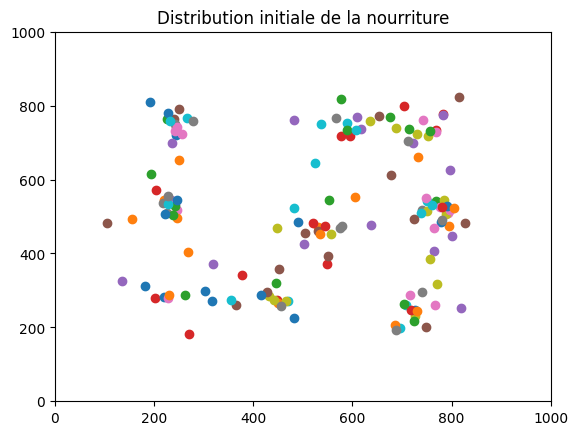

In [9]:
### INITIALISATION DE LA BOUFFE ###
food_group = [Food(canvas_width, canvas_height) for _ in range(initial_number_of_food)]

#Visualisation de la distribution initiale de la nourriture dans l'environnement
fig, ax = plt.subplots()
for food_element in food_group:
    ax.scatter(food_element.position[0], food_element.position[1])
ax.set_xlim(0, canvas_width)
ax.set_ylim(0, canvas_height)
plt.title("Distribution initiale de la nourriture")
plt.show()

### INITIALISATION DES ANIMAUX (UN GROUPE PAR ESPÈCE) ###
group_TFT = [TFT() for i in range(initial_TFT_population)]  # = [TFT() for i in range(initial_number_of_animals//2)
group_PushOver = [PushOver() for i in range(initial_PO_population)]
group_Judas =  [Judas() for i in range(initial_JD_population)]
group_Random =  [Confused() for i in range(initial_RD_population)]
group_TFTT =  [TitforTwoTats() for i in range(initial_TFTT_population)]
group_all_unshuffled = group_TFT + group_PushOver + group_Judas + group_Random + group_TFTT
group_all = random.sample(group_all_unshuffled, len(group_all_unshuffled))# concaténation des deux espèces en une population initiale

all_animals_quadrated = create_quadrated_group(group_all)

nourriture_quadrated = create_quadrated_group(food_group)


In [10]:
#Boucle principale du simulateur
toda_population = []  # suivi en temps réel du nombre d'animaux dans la simulation
TFT_population = []
TFTT_population = []
PO_population = []
JD_population = []
RD_population = []
food_amount = []
naissances = []
info_animaux = []
timing = []
pos_x = []
pos_y = []
for i in tqdm(range(sim_duration)):
    if initial_PO_population != 0:
        pos_x.append(group_PushOver[0].position[0]) # le premier PO, on enregistre ses déplacements
        pos_y.append(group_PushOver[0].position[1])
    elif initial_TFT_population != 0:
        pos_x.append(group_TFT[0].position[0]) # le premier PO, on enregistre ses déplacements
        pos_y.append(group_TFT[0].position[1])

    TFT_cnt = 0
    TFTT_cnt = 0
    PO_cnt = 0
    JD_cnt = 0
    RD_cnt = 0
    
    for quadrant in all_animals_quadrated:
        for animal in quadrant:
            if animal.species == "TFT":
                TFT_cnt += 1
            if animal.species == "TFTT":
                TFTT_cnt += 1
            if animal.species == "PO":
                PO_cnt += 1
            if animal.species == "JD":
                JD_cnt += 1
            if animal.species == "RD":
                RD_cnt += 1

    TFT_population.append(TFT_cnt)
    TFTT_population.append(TFTT_cnt)
    PO_population.append(PO_cnt)
    JD_population.append(JD_cnt)
    RD_population.append(RD_cnt)
    toda_population.append(TFT_cnt + PO_cnt + JD_cnt + RD_cnt + TFTT_cnt)  # Suivi démographique de la population totale

    naissances_par_h = update_group(all_animals_quadrated, nourriture_quadrated, i, info_animaux)  # Actualisation des animaux et de la bouffe présente
    #timing.append(temps)
    food = sum([len(quad) for quad in nourriture_quadrated])
    food_amount.append(food)
    if i % period_food_spawn == 0 and sum([len(quad) for quad in nourriture_quadrated]) < max_amount_of_food:
        new_food = [Food(canvas_width, canvas_height) for _ in
                    range(new_food_per_spawn)]  # Apparition spontanée de bouffe
        add_elements_to_quadrated_group(nourriture_quadrated, new_food)  # Ajout sur l'échiquier



 45%|████▍     | 4497/10000 [02:00<02:26, 37.46it/s]


KeyboardInterrupt: 

## Visualisation

Bouffe résiduelle :  2032


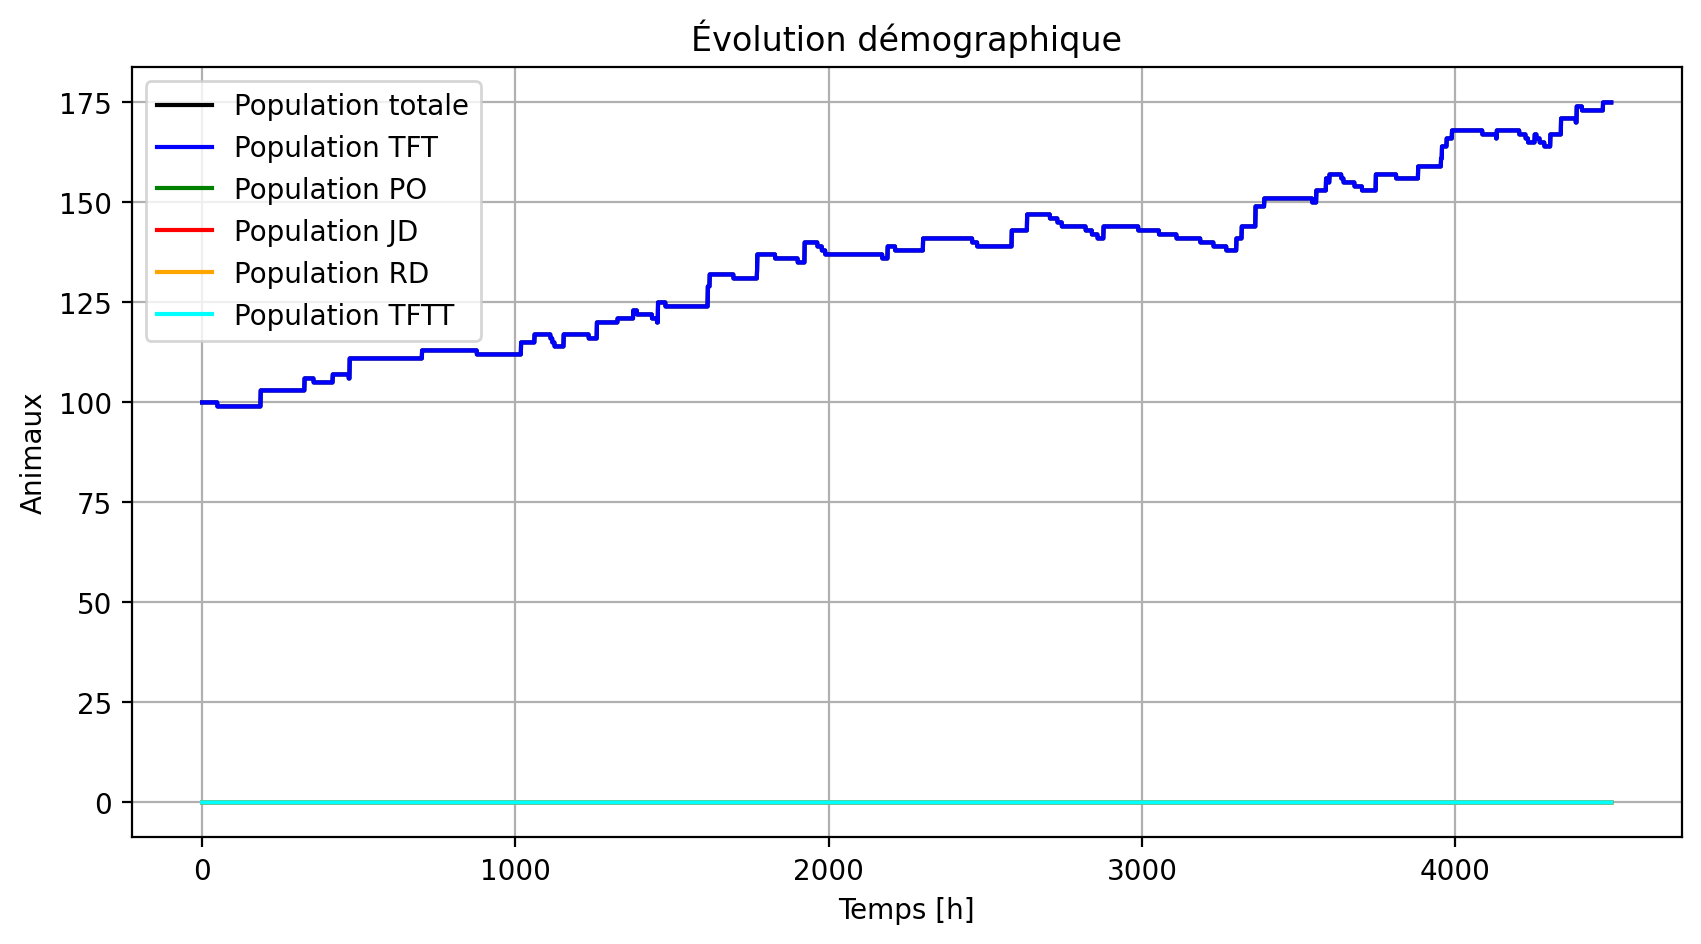

In [11]:
# print("Nombre cumulatif d'individus :", group_TFT[0].get_pop_compteur())
print("Bouffe résiduelle : ", sum(len(quadrant) for quadrant in nourriture_quadrated))

fig, ax = plt.subplots(1,1,figsize=(10,5), dpi=200)
ax.plot(toda_population, label="Population totale", color="black")
# ax.plot(food_amount, label="Quantité de nourriture", color="black", linestyle = "dashed")
ax.plot(TFT_population, label="Population TFT", color="blue")
ax.plot(PO_population, label="Population PO", color="green")
ax.plot(JD_population, label="Population JD", color="red")
ax.plot(RD_population, label="Population RD", color="orange")
ax.plot(TFTT_population, label="Population TFTT", color="cyan")
ax.grid()
ax.legend()
ax.set_xlabel("Temps [h]")
ax.set_ylabel("Animaux")
ax.set_title("Évolution démographique")
#plt.savefig(f"simulation_n0={initial_number_of_animals}_tf={sim_duration}.png")
plt.show()

## Infos-clés sur la simulation

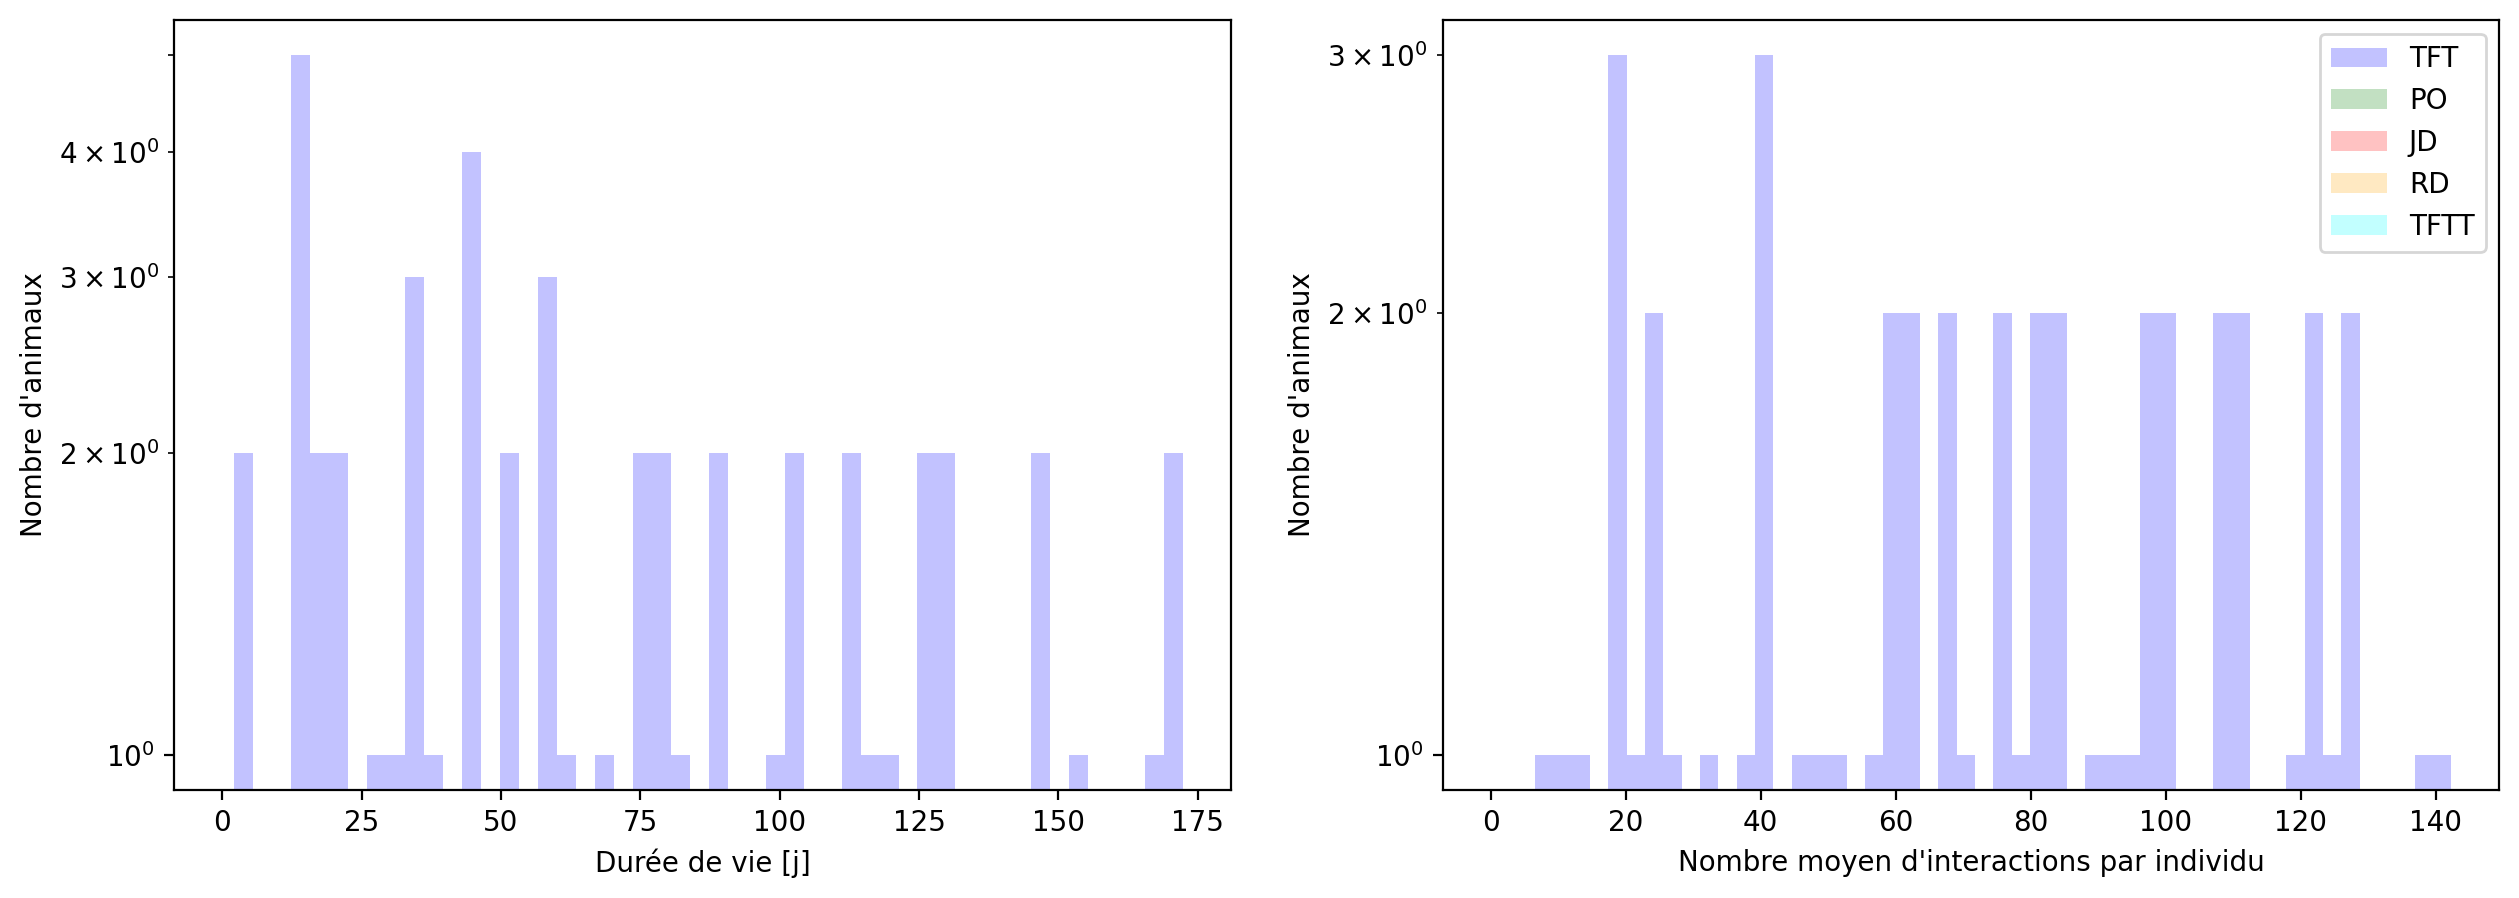

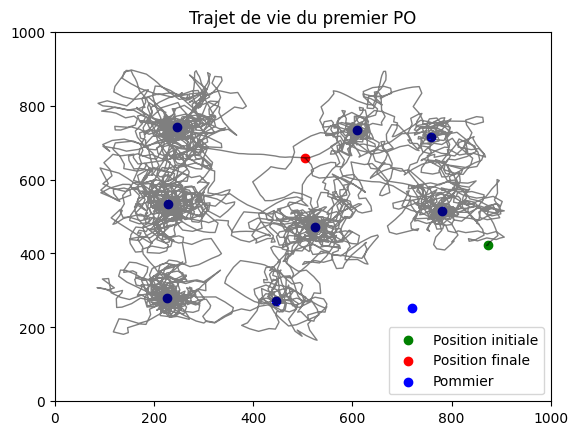

In [12]:
duree_de_vie = {}
duree_de_vie["TFT"], duree_de_vie["PO"], duree_de_vie["JD"], duree_de_vie["RD"], duree_de_vie["TFTT"] = [], [], [], [], []

interactions ={}
interactions["TFT"], interactions["PO"], interactions["JD"], interactions["RD"], interactions["TFTT"] = [], [], [], [], []

for i in info_animaux:
    espece = i[0] 
    duree_de_vie[espece].append(i[1])
    interactions[espece].append( np.mean([len(i[2][k]) for k in i[2].keys()]) )

#plt.figure(figsize=(10,8))
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
alpha_value = 1/len(duree_de_vie.keys())*1.2
ax[0].hist(np.array(duree_de_vie["TFT"])/24, bins=50, label="TFT", color="blue", alpha=alpha_value)
ax[0].hist(np.array(duree_de_vie["PO"])/24, bins=50, label="PO", color="green", alpha=alpha_value)
ax[0].hist(np.array(duree_de_vie["JD"])/24, bins=50, label="JD", color="red", alpha=alpha_value)
ax[0].hist(np.array(duree_de_vie["RD"])/24, bins=50, label="RD", color="orange", alpha=alpha_value)
ax[0].hist(np.array(duree_de_vie["TFTT"])/24, bins=50, label="TFTT", color="cyan", alpha=alpha_value)
ax[0].set_xlabel("Durée de vie [j]")
ax[0].set_ylabel("Nombre d'animaux")
ax[0].set_yscale("log")

ax[1].hist(np.array(interactions["TFT"]), bins=50, label="TFT", color="blue", alpha=alpha_value)
ax[1].hist(np.array(interactions["PO"]), bins=50, label="PO", color="green", alpha=alpha_value)
ax[1].hist(np.array(interactions["JD"]), bins=50, label="JD", color="red", alpha=alpha_value)
ax[1].hist(np.array(interactions["RD"]), bins=50, label="RD", color="orange", alpha=alpha_value)
ax[1].hist(np.array(interactions["TFTT"]), bins=50, label="TFTT", color="cyan", alpha=alpha_value)
ax[1].set_xlabel("Nombre moyen d'interactions par individu")
ax[1].set_ylabel("Nombre d'animaux")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

fig, ax = plt.subplots()
plt.title("Trajet de vie du premier PO")
ax.plot(pos_x, pos_y, linewidth = 1, alpha=0.5, color="black")
ax.scatter(pos_x[0], pos_y[0], label="Position initiale", color="green")
ax.scatter(pos_x[-1], pos_y[-1], label="Position finale", color="red")
ax.set_xlim(0, canvas_width)
ax.set_ylim(0, canvas_height)
cnt = 0
for i in attracteurs_pos:
    if cnt == 0:
        ax.scatter(i[0], i[1], color = "blue", label="Pommier")
    else:
        ax.scatter(i[0], i[1], color = "blue")
    cnt += 1

plt.legend()
plt.show()


## Enregistrement des cellules

In [182]:
#Run this cell to save results
import datetime
path_dir = "simul_resultats_rapport_prelim/"
dir_name = "tft_po_avec_interaction_1"
simul_description = "premiere simulation" #Courte description de la simulation qui ira dans le header du fichier

os.makedirs(f"{path_dir}{dir_name}")



f = open(f"{path_dir}{dir_name}/info", "w")
#Write header
f.write(f"{simul_description}\n\n")
f.write(f"Simulation effectuée le {datetime.datetime.now()}\nParamètres utilisés pour la simulation : \n")
for param in params.keys():
    f.write(f"{param} : {params[param]}\n")

f.close()

f = open(f"{path_dir}{dir_name}/titfortat", "w")
for pop in TFT_population:
    f.write(f"{pop}\n")

f.close()

f = open(f"{path_dir}{dir_name}/pushover", "w")
for pop in PO_population:
    f.write(f"{pop}\n")

f.close()

f = open(f"{path_dir}{dir_name}/judas", "w")
for pop in JD_population:
    f.write(f"{pop}\n")

f.close()

f = open(f"{path_dir}{dir_name}/bouffe", "w")

f.write(f"Quantité nourriture :\n")
for food in food_amount:
    f.write(f"{food}\n")
f.close()

